## Modeling Questions


* Is sub 50% F-score indicative of worse than guessing?
* Calc AUC score to all models
* Joblib all models
* Save all charts to a folder

### With more time
* I SHOULD consider only doing features available to my predicted audience (no drinking/drugs).
* SMOAT Upsample and try running all models on that data.
  * **train_test_split STRATIFIED before SMOTE, then only SMOTE the train set?**
  * do new .ipynb doing SMOTE and sampling!

## F1 score algebraic derivation

Dana and I derived the following score. If D is the proportion of UNSUCCESSES or NOs in the Ground Truth, then a "monkey predicted" F1 Score, aka if a coin flip was used to categorize the info and split evenly by
how many Ground Truths there are, then: 

$$D=\frac{1-D}{1.5-D}$$

#### KNN
* Lazy
* Fits **fast**, predicts **slow**
* Fits d-dimensional data in `O(dn)` time
* Higher memory (saves entire data set)
* Various implementations (weighted, uniform)


In [302]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sklearn
from sklearn.preprocessing import StandardScaler, Binarizer, LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate \
                                    ,cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.metrics import roc_curve, auc

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

# Helper Functions

In [191]:
target_names=['No','Yes']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def confusion_matrices(y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names,
                          title='Confusion matrix, without normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                          title='Confusion matrix, Normalized')

In [4]:
def plot_roc_curve(fit_model, title):
    y_score=fit_model.predict_proba(X_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    # Plotting the Baseline
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.grid(which='major')
    plt.title(f"{title} ROC curve")
    s= 'AUC: ' + str(round(metrics.roc_auc_score(y_test, fit_model.predict(X_test)),3))
    plt.text(0.75, 0.25, s=s, ha='right', va='bottom', fontsize=14,
             bbox=dict(facecolor='grey', alpha=0.5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');

In [5]:
def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs) 
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

# cut = np.linspace(0,1,100)
# cost = np.zeros_like(cut)
# from sklearn.model_selection import KFold, cross_val_predict
# obs = np.ravel(y)

# K = 20
# for j in range(K):
#     folds = KFold(n_splits=5,shuffle=True)
#     prob = cross_val_predict(logreg,X,np.ravel(y),cv=folds,method='predict_proba',n_jobs=5)[:,1]
#     getcost = makecost(obs,prob,falsepos_cost=20,falseneg_cost=25)
#     currentcost = getcost(cut)/X.shape[0]
#     cost += currentcost
#     plt.plot(cut, currentcost,c='C0',alpha=0.05)
# cost /= K
# plt.plot(cut,cost,c='C0')
# plt.xlabel('cutoff')
# plt.ylabel('Expected cost per data point');

In [106]:
def number_of_uniques(df):
    for i in df.columns:
        print(i,":", len(df[i].unique()))
        
def number_of_NaN(df):
    for i in df.columns:
        if df[i].isna().sum() != 0:
            print(i,":", df[i].isna().sum())

# Load Data

In [149]:
cupid = pd.read_hdf('data/cupid_cleaned.hd5', key='df', mode='r')
#cupid = load_pd_pkl('data/cupid_cleaned')

In [154]:
# Create binary "wants_kids" YES vs NO from the more options
cupid['wants_kids_binary'] = ['yes' if x == 'yes' else 'no' if x == 'no' else np.nan for x in cupid['wants_kids']]
cupid['status_available'] =  ['yes' if x == 'available' else 'yes' if x == 'single' else np.nan for x in cupid['status']]


target = ['wants_kids_binary']
continuous = ['age', 'height']
# bi_categorical = ['sex', 'signs_fun', 'signs_unimportant', 'signs_important',
#                      'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                      'religion_serious', ]
# mult_categorical = ['body_type', 'drinks', 'drugs', 'income', 'orientation', 'status',
#                       'diet_intensity', 'diet_choice', 'primary_ethnicity',
#                       'has_kids','likes_cats', 'likes_dogs', 'dislikes_cats', 'dislikes_dogs',
#                       'has_cats', 'has_dogs','english_fluent','english_poor','spanish_fluent',
#                       'spanish_not_poorly','religion_name','new_education',]



# remove from bi: 'signs_fun', 'signs_unimportant', 'signs_important', 'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                     'religion_serious',

bi_categorical = ['sex', 'signs_fun', 'signs_unimportant', 'signs_important', 
                  'religion_unserious', 'religion_laughing', 'religion_somewhat', 'religion_serious']


# remove from multi:  'new_education','likes_cats', 'likes_dogs', 'dislikes_cats', 
#          'dislikes_dogs', 'has_cats', 'has_dogs', 'primary_ethnicity', , 
#          'english_fluent','english_poor','spanish_fluent','spanish_not_poorly',
#          'diet_intensity', 'diet_choice', 'religion_name'
                      
mult_categorical = ['orientation', 'status_available',
                      'has_kids', 'drinks', 'smokes', 'religion_name',]


# Assign feature groupings
columns = bi_categorical + mult_categorical + target

# Create DF of everything
df = cupid[target + continuous + bi_categorical + mult_categorical]

### Change data type of age
df['age'] = df.age.astype(float)

df = df.dropna()

# Split DF of only standardized/scaled features
scaled_features = df.copy().loc[:, continuous]

# Tranform age and height (standardized features)
features = scaled_features[continuous]
features = StandardScaler().fit_transform(features.values)
scaled_features[continuous] = features

# Create dummy variables for original features, then combine back with scaled features
dummies = pd.get_dummies(df.loc[:, columns], columns=columns, drop_first=False)
df = scaled_features.join(dummies)

# Drop all "placeholder" columns
df.drop(df.filter(regex='placeholder'), axis=1, inplace=True)

# Drop status column. Only available and single people now in dataset.
df.drop(columns="status_available_yes", axis=1, inplace=True)
# Drop unused binary column
df.drop('wants_kids_binary_no', axis=1, inplace=True)

# SETUP MODELING DATA

X = df.drop('wants_kids_binary_yes', axis=1)
y = df['wants_kids_binary_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


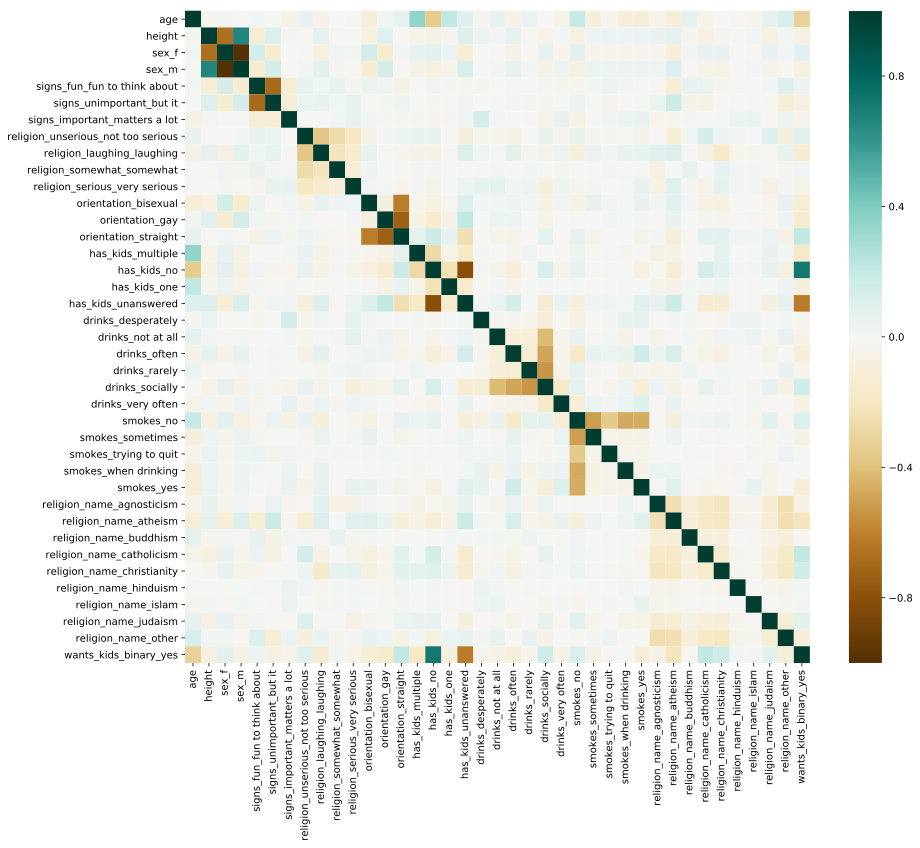

In [159]:
fig, ax = plt.subplots(figsize=(14,12))
sns.heatmap(df.corr(), xticklabels=True, cmap='BrBG');

In [160]:
df.wants_kids_binary_yes.value_counts()

0    3172
1    2292
Name: wants_kids_binary_yes, dtype: int64

In [161]:
no, yes = df.wants_kids_binary_yes.value_counts()

In [162]:
df.wants_kids_binary_yes.sum()

2292

In [163]:
yes / (no+ yes)

0.41947291361639827

# K-Nearest Neighbors (KNN)

## GridSearchCV

### Warning, this is quite computationally heavy! (30+ minutes)


### A few RandomizedSearchCV searches helped me narrow the range to between K = 1-8. Both uniform and distance were the best results for weight.

In [167]:
knn = KNeighborsClassifier()

# define the parameter values that should be searched
#k_range = list(range(1, 7))
#weight_options = ['uniform', 'distance']

k_range = list(range(40,80))
# weight_options = ['uniform']
weight_options = ['uniform', 'distance']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
# print(param_grid)

# instantiate the grid
grid_knn = RandomizedSearchCV(knn, param_grid, cv=10, scoring='f1', n_jobs=5, n_iter=20)

# fit the grid with data
grid_knn.fit(X_train, y_train)

# examine the best model
print(grid_knn.best_score_)
print(grid_knn.best_params_)
print(grid_knn.best_estimator_)

0.8556331774570389
{'weights': 'uniform', 'n_neighbors': 50}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=50, p=2,
           weights='uniform')


In [177]:
grid_knn = grid_knn.best_estimator_

In [171]:
joblib.dump(grid_knn, 'wants_kids_models/knn.joblib')  # Save model to disk

['wants_kids_models/knn.joblib']

In [192]:
y_pred_knn = grid_knn.predict(X_test)
print("test f1:", metrics.f1_score(y_test, y_pred_knn))
print("test accuracy:", metrics.accuracy_score(y_test, y_pred_knn))

test f1: 0.8638743455497383
test accuracy: 0.8731707317073171


In [193]:
print('AUC:', round(metrics.roc_auc_score(y_test, y_pred_knn),3))

AUC: 0.885


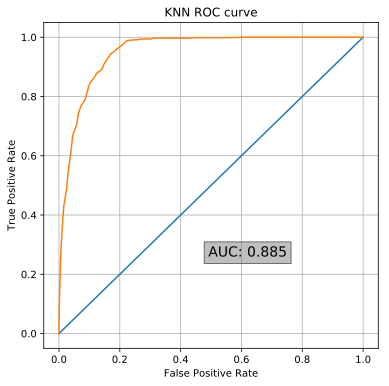

In [180]:
plot_roc_curve(grid_knn, 'KNN')

classification report: 

              precision    recall  f1-score   support

          No       0.96      0.81      0.88       952
         Yes       0.79      0.96      0.86       688

   micro avg       0.87      0.87      0.87      1640
   macro avg       0.88      0.89      0.87      1640
weighted avg       0.89      0.87      0.87      1640

Confusion matrix, without normalization
[[772 180]
 [ 28 660]]
Normalized confusion matrix
[[0.81 0.19]
 [0.04 0.96]]


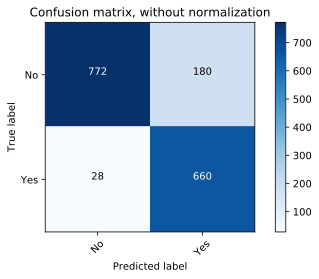

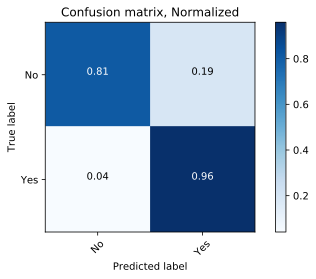

In [195]:
print("classification report: \n")
print(metrics.classification_report(y_test, y_pred_knn,target_names=target_names ))
confusion_matrices(y_pred_knn)

### Now messing with THRESHOLD

In [206]:
y_prob = grid_knn.predict_proba(X_test)

y_pred_knn_prob = y_prob[:,1] >= 0.7

print(metrics.classification_report(y_test, y_pred_knn_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_knn_prob))

              precision    recall  f1-score   support

          No       0.88      0.91      0.89       952
         Yes       0.86      0.82      0.84       688

   micro avg       0.87      0.87      0.87      1640
   macro avg       0.87      0.86      0.87      1640
weighted avg       0.87      0.87      0.87      1640

accuracy:  0.8707317073170732


Confusion matrix, without normalization
[[862  90]
 [122 566]]
Normalized confusion matrix
[[0.91 0.09]
 [0.18 0.82]]


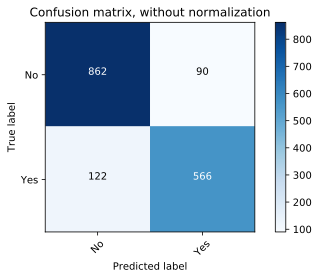

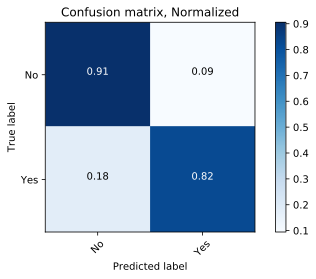

In [207]:
confusion_matrices(y_pred_knn_prob)

# Logistic Regression

In [214]:
logreg = LogisticRegression(max_iter=500, random_state=42)
# define the parameter values that should be searched
C_options = [0.5, 1, 2, 3]
duals = [False]
tol_options = [1e-3, 1e-2, 1e-1]
pen_options = ['l2']
solver_options = ['liblinear', 'sag', 'newton-cg', 'lbfgs']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=C_options, dual=duals, tol=tol_options, penalty=pen_options, solver=solver_options)
# print(param_grid)

# instantiate the grid
grid_lr = RandomizedSearchCV(logreg, param_grid, cv=10, scoring='f1', n_jobs=6, n_iter=30)

# fit the grid with data
grid_lr.fit(X_train, y_train);

# examine the best model
print(grid_lr.best_score_)
print(grid_lr.best_params_)
print(grid_lr.best_estimator_)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0.8537012483382428
{'tol': 0.01, 'solver': 'liblinear', 'penalty': 'l2', 'dual': False, 'C': 2}
LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.01, verbose=0, warm_start=False)


In [215]:
grid_lr = grid_lr.best_estimator_

In [216]:
joblib.dump(grid_lr, 'wants_kids_models/logreg.joblib')  # Save model to disk

['wants_kids_models/logreg.joblib']

In [217]:
y_pred_logreg = grid_lr.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_logreg))

print(metrics.classification_report(y_test, grid_lr.predict(X_test)))


0.876219512195122
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       952
           1       0.82      0.90      0.86       688

   micro avg       0.88      0.88      0.88      1640
   macro avg       0.87      0.88      0.87      1640
weighted avg       0.88      0.88      0.88      1640



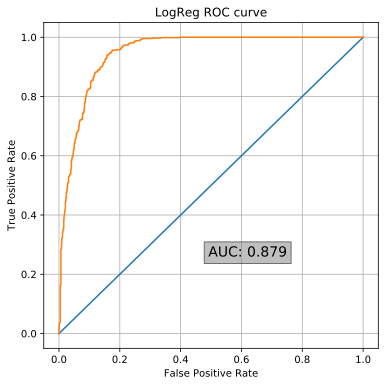

In [218]:
plot_roc_curve(grid_lr, "LogReg")

Confusion matrix, without normalization
[[818 134]
 [ 69 619]]
Normalized confusion matrix
[[0.86 0.14]
 [0.1  0.9 ]]


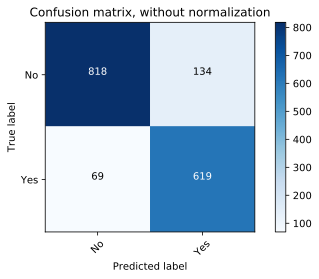

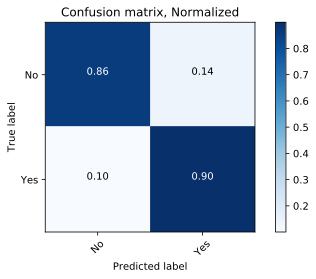

In [219]:
confusion_matrices(y_pred_logreg)

### Now messing with THRESHOLD

In [230]:
y_prob = grid_lr.predict_proba(X_test)

y_pred_lr_prob = y_prob[:,1] >= 0.4

print(metrics.classification_report(y_test, y_pred_lr_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_lr_prob))

              precision    recall  f1-score   support

          No       0.96      0.83      0.89       952
         Yes       0.80      0.95      0.87       688

   micro avg       0.88      0.88      0.88      1640
   macro avg       0.88      0.89      0.88      1640
weighted avg       0.89      0.88      0.88      1640

accuracy:  0.8798780487804878


Confusion matrix, without normalization
[[791 161]
 [ 36 652]]
Normalized confusion matrix
[[0.83 0.17]
 [0.05 0.95]]


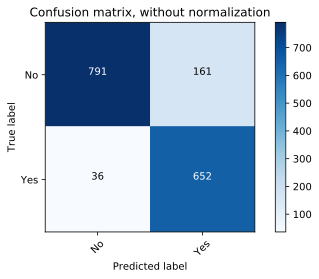

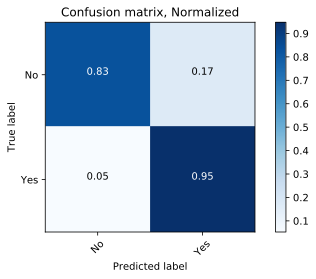

In [231]:
confusion_matrices(y_pred_lr_prob)

# Support Vector Machine (SVM)

In [232]:
svm = SVC(probability = True, random_state=42)

Cs=[0.5, 1, 1.5]
kernels = ['rbf', 'sigmoid', 'linear']
gammas = ['scale', 'auto']
tols = [1e-5, 1e-4, 1e-3, 1e-2]

# Cs=[.75, 1, 1.25, 1.5, 2]
# kernels = ['linear','rbf','sigmoid']
# gammas = ['scale', 'auto']
# tols = [.00001, .0001, .001, .01,]

param_grid = dict(C=Cs, tol=tols, gamma=gammas, kernel=kernels)

grid_svm = RandomizedSearchCV(svm, param_grid, cv=10, scoring='f1', n_jobs=-1, n_iter=10)

grid_svm.fit(X_train, y_train)

print(grid_svm.best_score_)
print(grid_svm.best_params_)
print(grid_svm.best_estimator_)

0.8662184228341968
{'tol': 0.01, 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.5}
SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.01,
  verbose=False)


In [233]:
grid_svm = grid_svm.best_estimator_

In [234]:
y_pred_best_svm = grid_svm.predict(X_test)

print(metrics.classification_report(y_test, y_pred_best_svm))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       952
           1       0.82      0.94      0.88       688

   micro avg       0.89      0.89      0.89      1640
   macro avg       0.89      0.90      0.89      1640
weighted avg       0.90      0.89      0.89      1640



In [235]:
metrics.accuracy_score(y_test, y_pred_best_svm)

0.8878048780487805

In [236]:
joblib.dump(grid_svm, 'wants_kids_models/SVM.joblib')  # Save model to disk

['wants_kids_models/SVM.joblib']

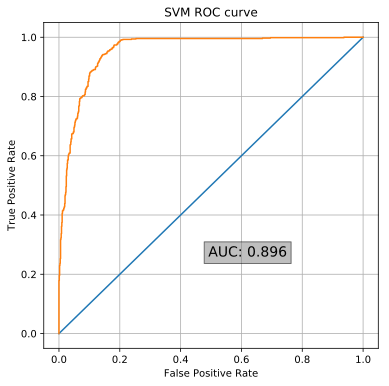

In [237]:
plot_roc_curve(grid_svm, 'SVM')

Confusion matrix, without normalization
[[806 146]
 [ 38 650]]
Normalized confusion matrix
[[0.85 0.15]
 [0.06 0.94]]


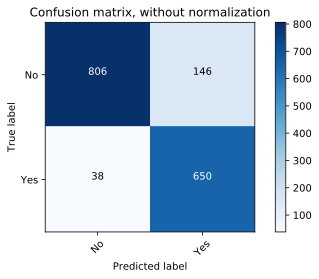

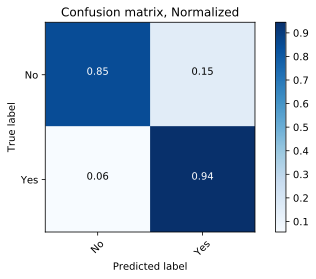

In [238]:
confusion_matrices(y_pred_best_svm)

### Now messing with THRESHOLD

In [245]:
y_prob = grid_svm.predict_proba(X_test)

y_pred_svm_prob = y_prob[:,1] > 0.4

print(metrics.classification_report(y_test, y_pred_svm_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_svm_prob))

              precision    recall  f1-score   support

          No       0.95      0.86      0.90       952
         Yes       0.83      0.94      0.88       688

   micro avg       0.89      0.89      0.89      1640
   macro avg       0.89      0.90      0.89      1640
weighted avg       0.90      0.89      0.89      1640

accuracy:  0.8914634146341464


Confusion matrix, without normalization
[[818 134]
 [ 44 644]]
Normalized confusion matrix
[[0.86 0.14]
 [0.06 0.94]]


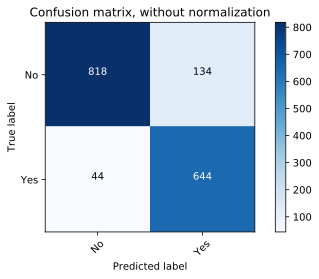

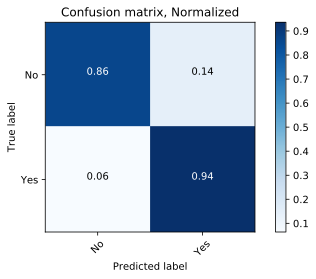

In [246]:
confusion_matrices(y_pred_svm_prob)

# Decision Trees

In [247]:
dt = DecisionTreeClassifier(random_state=42)

criterions = ['gini', 'entropy']    

param_grid = dict(criterion=criterions)

grid_dt = GridSearchCV(dt, param_grid, scoring='f1', cv=10, n_jobs=5)

grid_dt.fit(X_train, y_train)

print(grid_dt.best_score_)
print(grid_dt.best_params_)
print(grid_dt.best_estimator_)

0.8097385198520298
{'criterion': 'entropy'}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [248]:
grid_dt = grid_dt.best_estimator_

In [249]:
joblib.dump(grid_dt, 'wants_kids_models/DecisionTree.joblib')  # Save model to disk

['wants_kids_models/DecisionTree.joblib']

In [250]:
y_pred_dtree = grid_dt.predict(X_test)

print(metrics.classification_report(y_test, y_pred_dtree))
print('accuracy:', metrics.accuracy_score(y_test, y_pred_dtree))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       952
           1       0.82      0.77      0.79       688

   micro avg       0.83      0.83      0.83      1640
   macro avg       0.83      0.82      0.83      1640
weighted avg       0.83      0.83      0.83      1640

accuracy: 0.8317073170731707


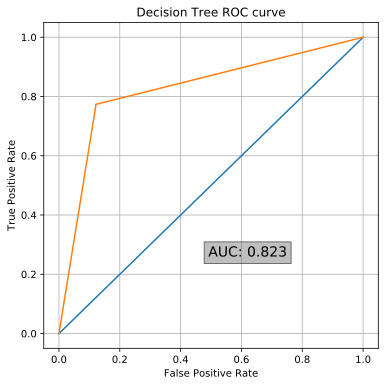

In [251]:
plot_roc_curve(grid_dt, "Decision Tree")

Confusion matrix, without normalization
[[837 115]
 [161 527]]
Normalized confusion matrix
[[0.88 0.12]
 [0.23 0.77]]


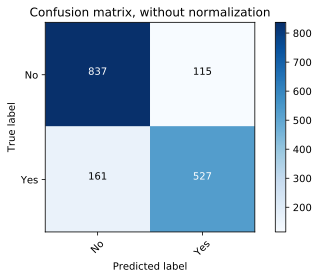

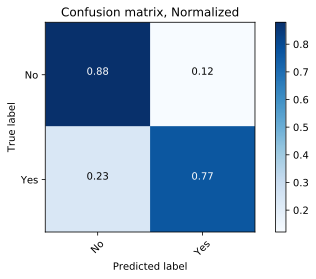

In [252]:
confusion_matrices(y_pred_dtree)

### Now messing with THRESHOLD - Nothing in Decision Tree matters.

In [253]:
y_prob = grid_dt.predict_proba(X_test)

y_pred_dt_prob = y_prob[:,1] > 0.5

print(metrics.classification_report(y_test, y_pred_dt_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_dt_prob))

              precision    recall  f1-score   support

          No       0.84      0.88      0.86       952
         Yes       0.82      0.77      0.79       688

   micro avg       0.83      0.83      0.83      1640
   macro avg       0.83      0.82      0.83      1640
weighted avg       0.83      0.83      0.83      1640

accuracy:  0.8317073170731707


Confusion matrix, without normalization
[[837 115]
 [161 527]]
Normalized confusion matrix
[[0.88 0.12]
 [0.23 0.77]]


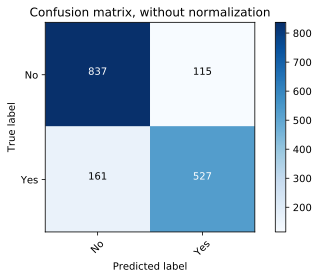

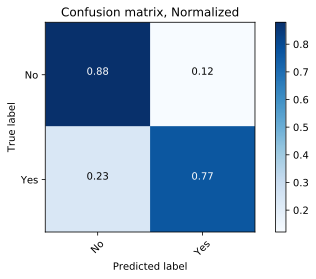

In [254]:
confusion_matrices(y_pred_dt_prob)

# Random Forrest

In [263]:
rf = RandomForestClassifier(random_state=42)

criterions = ['gini', 'entropy']
n_ests = [100, 500, 1000]
    
param_grid = dict(criterion=criterions, n_estimators=n_ests)

grid_rf = GridSearchCV(rf, param_grid, scoring='f1', cv=10, n_jobs=5)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

0.8551157624411352
{'criterion': 'entropy', 'n_estimators': 500}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [264]:
grid_rf = grid_rf.best_estimator_

In [265]:
joblib.dump(grid_rf, 'wants_kids_models/RandomForest.joblib')  # Save model to disk

['wants_kids_models/RandomForest.joblib']

In [266]:
y_pred_rf = grid_rf.predict(X_test)

print(metrics.classification_report(y_test, y_pred_rf))
print('accuracy:', metrics.accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       952
           1       0.84      0.86      0.85       688

   micro avg       0.87      0.87      0.87      1640
   macro avg       0.87      0.87      0.87      1640
weighted avg       0.87      0.87      0.87      1640

accuracy: 0.8707317073170732


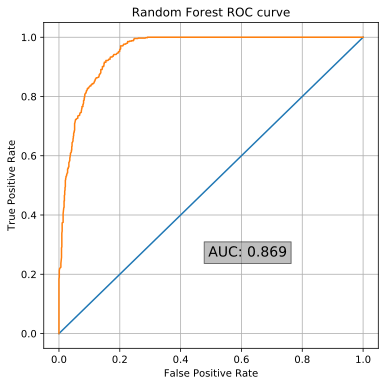

In [267]:
plot_roc_curve(grid_rf, "Random Forest")

Confusion matrix, without normalization
[[839 113]
 [ 99 589]]
Normalized confusion matrix
[[0.88 0.12]
 [0.14 0.86]]


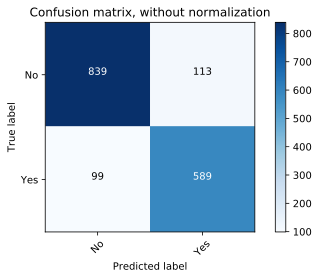

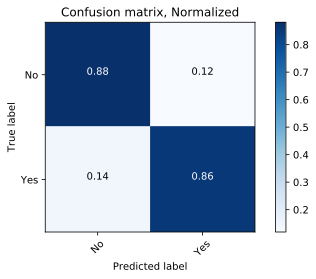

In [268]:
confusion_matrices(y_pred_rf)

### Now messing with THRESHOLD

In [275]:
y_prob = grid_rf.predict_proba(X_test)

y_pred_rf_prob = y_prob[:,1] > 0.35

print(metrics.classification_report(y_test, y_pred_rf_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_rf_prob))

              precision    recall  f1-score   support

          No       0.95      0.81      0.88       952
         Yes       0.79      0.94      0.86       688

   micro avg       0.87      0.87      0.87      1640
   macro avg       0.87      0.88      0.87      1640
weighted avg       0.88      0.87      0.87      1640

accuracy:  0.8676829268292683


Confusion matrix, without normalization
[[775 177]
 [ 40 648]]
Normalized confusion matrix
[[0.81 0.19]
 [0.06 0.94]]


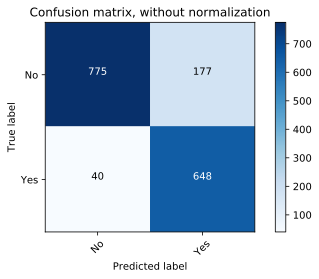

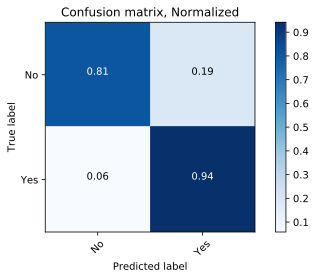

In [276]:
confusion_matrices(y_pred_rf_prob)

# Gradient Boosting

In [284]:
gb = GradientBoostingClassifier(random_state=42)

losses = ['deviance', 'exponential']
lrs = [.01, .05, .1]
n_ests = [50, 100, 200]
subsamples=[0.5, .75, 1]
maxd = [3,5]
tols = [1e-6, 1e-5, 1e-4]
    
    

param_grid = dict(loss=losses, learning_rate=lrs, n_estimators=n_ests, subsample=subsamples,
                 max_depth=maxd, tol=tols)

grid_gb = RandomizedSearchCV(gb, param_grid, scoring='f1', cv=10, n_jobs=-1, n_iter=60)

grid_gb.fit(X_train, y_train)

print(grid_gb.best_score_)
print(grid_gb.best_params_)
print(grid_gb.best_estimator_)

0.8699952933502605
{'tol': 1e-06, 'subsample': 0.75, 'n_estimators': 200, 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.05}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.75, tol=1e-06, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [289]:
grid_gb = grid_gb.best_estimator_
grid_gb

AttributeError: 'GradientBoostingClassifier' object has no attribute 'best_estimator_'

In [290]:
joblib.dump(grid_gb, 'wants_kids_models/GradientBoosting.joblib')  # Save model to disk

['wants_kids_models/GradientBoosting.joblib']

In [291]:
y_pred_gb = grid_gb.predict(X_test)

metrics.f1_score(y_test, y_pred_gb)

0.8550932568149211

In [292]:
print(metrics.classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       952
           1       0.84      0.87      0.86       688

   micro avg       0.88      0.88      0.88      1640
   macro avg       0.87      0.88      0.87      1640
weighted avg       0.88      0.88      0.88      1640



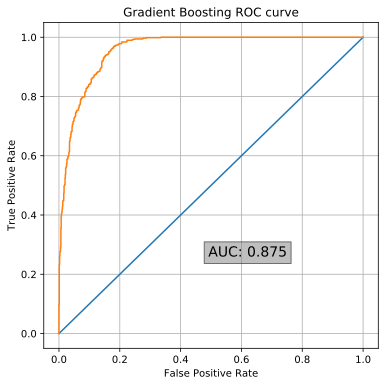

In [293]:
plot_roc_curve(grid_gb, "Gradient Boosting")

Confusion matrix, without normalization
[[842 110]
 [ 92 596]]
Normalized confusion matrix
[[0.88 0.12]
 [0.13 0.87]]


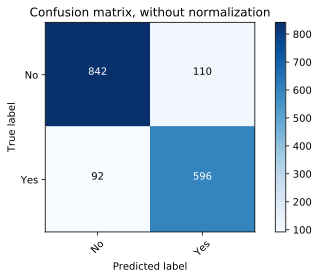

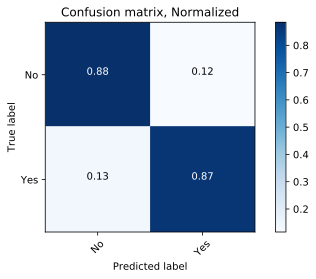

In [294]:
confusion_matrices(y_pred_gb)

### Now messing with THRESHOLD

In [296]:
y_prob = grid_gb.predict_proba(X_test)

y_pred_gb_prob = y_prob[:,1] > 0.5

print(metrics.classification_report(y_test, y_pred_gb_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_gb_prob))

              precision    recall  f1-score   support

          No       0.90      0.88      0.89       952
         Yes       0.84      0.87      0.86       688

   micro avg       0.88      0.88      0.88      1640
   macro avg       0.87      0.88      0.87      1640
weighted avg       0.88      0.88      0.88      1640

accuracy:  0.8768292682926829


Confusion matrix, without normalization
[[842 110]
 [ 92 596]]
Normalized confusion matrix
[[0.88 0.12]
 [0.13 0.87]]


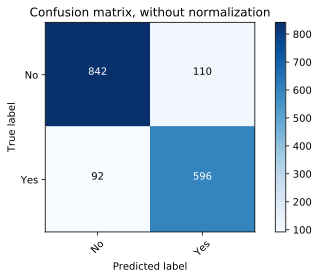

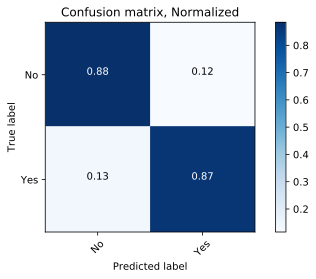

In [297]:
confusion_matrices(y_pred_gb_prob)

# Naive Bayes

In [304]:
bern = BernoulliNB()
bern.fit(X_train, y_train)
y_pred_bern = bern.predict(X_test)
metrics.f1_score(y_test, y_pred_bern)

0.8466757123473542

In [298]:
nb = GaussianNB()

nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [299]:
joblib.dump(nb, 'wants_kids_models/NaiveBayesGaussian.joblib')  # Save model to disk

['wants_kids_models/NaiveBayesGaussian.joblib']

In [300]:
y_pred_nb = nb.predict(X_test)

In [301]:
metrics.f1_score(y_test, y_pred_nb)

0.8495692511597085

In [307]:
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       952
           1       0.78      0.93      0.85       688

   micro avg       0.86      0.86      0.86      1640
   macro avg       0.86      0.87      0.86      1640
weighted avg       0.87      0.86      0.86      1640



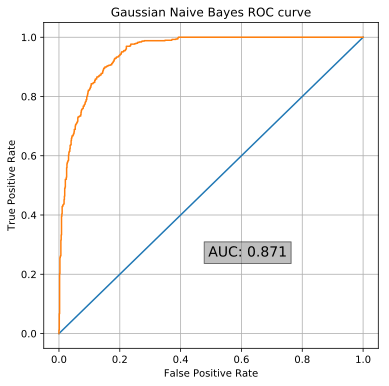

In [308]:
plot_roc_curve(nb, "Gaussian Naive Bayes")

Confusion matrix, without normalization
[[772 180]
 [ 47 641]]
Normalized confusion matrix
[[0.81 0.19]
 [0.07 0.93]]


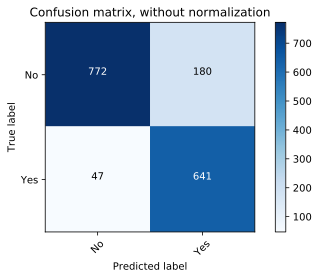

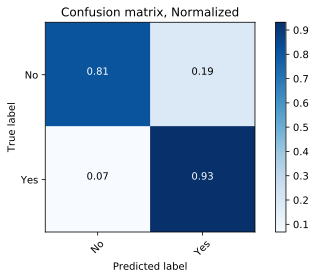

In [309]:
confusion_matrices(y_pred_nb)

### Now messing with THRESHOLD

In [313]:
y_prob = nb.predict_proba(X_test)

y_pred_nb_prob = y_prob[:,1] > 0.5

print(metrics.classification_report(y_test, y_pred_nb_prob, target_names=target_names))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_nb_prob))

              precision    recall  f1-score   support

          No       0.94      0.81      0.87       952
         Yes       0.78      0.93      0.85       688

   micro avg       0.86      0.86      0.86      1640
   macro avg       0.86      0.87      0.86      1640
weighted avg       0.87      0.86      0.86      1640

accuracy:  0.8615853658536585


Confusion matrix, without normalization
[[772 180]
 [ 47 641]]
Normalized confusion matrix
[[0.81 0.19]
 [0.07 0.93]]


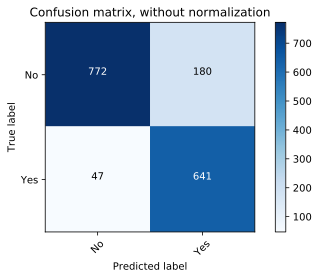

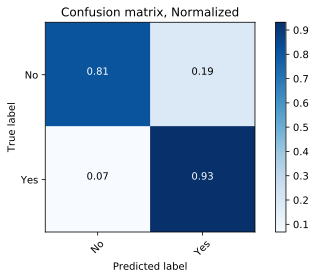

In [314]:
confusion_matrices(y_pred_nb_prob)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4))
fig.set_figwidth(10)
fig.set_figheight(6)

fig.suptitle('Main Title',fontsize = 16)

ax[0].plot(new_x,new_y)
ax[0].set_title('Line Chart')

ax[1].bar(new_x,new_y)
ax[1].set_title('Bar Chart');